# Checking Data Availability with the Rune Labs API/SDK

This tutorial demonstrates how to check data availability using "availability" representations with the Rune Labs API/SDK. This is done using stream metadata (or stream IDs), which is explained in [a previous tutorial](04_querying_stream_metadata.ipynb).

This tutorial follows: [Understanding Types of Data Streams Used by the Rune Labs API/SDK](06_stream_types.ipynb).

For detailed information:
* [Rune Labs API documentation](https://docs.runelabs.io/stream/v2/)
* [Rune Labs SDK documentation](https://runeq.readthedocs.io/en/latest/)
* [Rune Labs open source code respository](https://github.com/rune-labs/opensource) (which includes this notebook)

---

## Set Up

Initialize the Rune SDK with your platform credentials, as described previously: [Getting Started with the Rune Labs API/SDK](01_getting_started_with_Rune_SDK.ipynb)

In [1]:
# Initialize the SDK.
from runeq import initialize

initialize()

To confirm that you have successfully initialized the SDK in your current script or notebook, pull your own information using the `get_current_user()` function.

In [2]:
# Get the ID and name of the current user, based on API credentials.
from runeq.resources.user import get_current_user

my_user = get_current_user()
print(my_user)

User(id="user-b9c372f2b315a6c6cfd9b5ef7eba81e5ef7866d1,user", name="Gavin Philips")


In [3]:
# Confirm user's current active org.
print('Active Org:', my_user.active_org_name)

Active Org: Rune Demo


---

## Utility Functions

Define a utility function, which will be used below to visualize data availability.

In [4]:
import matplotlib.pyplot as plt

def plot_availability(availability_df):
    """
    Plot a dataframe of availability data.
    
    availability_df is a Pandas dataframe, with one 'time' column of ISO 8601 format timestamps,
    and at least one column of binary availability data.

    """
    # Copy to avoid modifying original dataframe.
    df = availability_df.copy()
    
    # Convert ISO timestamps to dates.
    df.time = pd.to_datetime(df.time).dt.date

    # Get a list of streams for axes.
    cols = df.columns.tolist()
    cols.remove('time')

    # Plot the availability streams to visualize overlap.
    plt.figure(figsize=(10,3))
    plt.imshow(
        df[cols].T, 
        cmap ="binary",
    );
    plt.xticks(range(len(df)), df.time, rotation='vertical')
    plt.yticks(range(len(cols)), cols) 
    plt.show()

---

## Patients

[Exploring Organizations and Patients with the Rune Labs API/SDK](02_exploring_organizations_and_patients.ipynb) includes instructions to copy a `patient_id` from a patient in your org. Paste that `patient_id` into the cell below.

We could also explore stream metadata across all patients in the org, but for simplicity, we'll focus on one in this tutorial.

In [5]:
# Set ID of example patient from your org.
patient_id = 'e3dd146f74714135a11128e99f1557f0'

---

## Stream Metadata

Finding and accessing data using our API/SDK is a two-step process:
1. Query for data streams using a desired set of parameters
    * Result: A set of stream metadata, which describes a set of streams
2. Use the resulting stream IDs to pull the desired data for a chosen time frame
    * Result: Actual data in a chosen format

**However**, we can change the second step if we are interested in the *availability* of the data, rather than the data itself:
1. Query for data streams using a desired set of parameters
    * Result: A set of stream metadata, which describes a set of streams
2. Use the resulting stream IDs to pull **a boolean representation of available data**
    * Result: One or more boolean streams, with a chosen temporal resolution (bin size), and a constant sampling rate

We covered the first step in [a previous tutorial](04_querying_stream_metadata.ipynb), and will continue to the second step here, using the same example.

Use the [get_patient_stream_metadata()](https://runeq.readthedocs.io/en/latest/pages/resources.html#runeq.resources.stream_metadata.get_patient_stream_metadata) function to query for the metadata of the desired stream(s):

In [6]:
# Query for the specific desired stream(s).
from runeq.resources.stream_metadata import get_patient_stream_metadata
import pandas as pd

tremor_metadata = get_patient_stream_metadata(patient_id=patient_id, algorithm='ingest-strive-applewatch-md.0', measurement='tremor', severity='all', stream_type_id='duration')
tremor_metadata_df = tremor_metadata.to_dataframe()

tremor_metadata_df

,created_at,algorithm,device_id,patient_id,stream_type,min_time,max_time,parameters,category,severity,measurement,id
0,1.668829e+09,ingest-strive-applewatch-md.0,LARICRKw,e3dd146f74714135a11128e99f1557f0,"{'name': 'Duration', 'description': 'Durations...",1.668225e+09,1.693247e+09,"{'category': 'symptom', 'severity': 'all', 'me...",symptom,all,tremor,83257a46c877b96f4c639d2d3961401baf27d50b69f777...


We've narrowed down our query to retrieve the metadata of exactly one stream. Now we can use this metadata to check the availability of the data.

---

## Data Availability: One Stream

When monitoring an ongoing study, or analyzing a data set, it's helpful to know *what* data is available, and *when* it was gathered. These questions can be answered by pulling all of the available data from the API, but for long periods of time or dense streams that may not be an efficient approach. Instead, "availability" representations show where data exists, at a desired resolution.

For example, while monitoring study compliance, you may want to confirm that a particular type of data has been gathered each day within the last month.

To do this, set a resolution of one day, and use the `get_stream_availability_dataframe()` function on the desired stream's `StreamMetadata` object.

In [7]:
# Get the first stream in the set.
tremor_stream = next(iter(tremor_metadata))
tremor_stream

StreamMetadata(id="83257a46c877b96f4c639d2d3961401baf27d50b69f777c7eee9aab4413c5e98")

In [8]:
# Set start and end times as unix timestamps. 
start_time = 1682899200 # 2023-05-01 (midnight UTC)
end_time = 1685577600 # 2023-06-01 (midnight UTC)

# Set temporal resolution (bin size) in seconds.
resolution = 60 * 60 * 24  # 1 day

# Pull the availability representation for the chosen stream.
tremor_availability = tremor_stream.get_stream_availability_dataframe(
    start_time=start_time,
    end_time=end_time,
    resolution=resolution,
)

tremor_availability.head()

,time,availability,stream_id,stream_type_id,patient_id,device_id,algorithm,category,severity,measurement
0,2023-05-01T00:00:00Z,0,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,duration,e3dd146f74714135a11128e99f1557f0,LARICRKw,ingest-strive-applewatch-md.0,symptom,all,tremor
1,2023-05-02T00:00:00Z,0,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,duration,e3dd146f74714135a11128e99f1557f0,LARICRKw,ingest-strive-applewatch-md.0,symptom,all,tremor
2,2023-05-03T00:00:00Z,0,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,duration,e3dd146f74714135a11128e99f1557f0,LARICRKw,ingest-strive-applewatch-md.0,symptom,all,tremor
3,2023-05-04T00:00:00Z,0,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,duration,e3dd146f74714135a11128e99f1557f0,LARICRKw,ingest-strive-applewatch-md.0,symptom,all,tremor
4,2023-05-05T00:00:00Z,1,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,duration,e3dd146f74714135a11128e99f1557f0,LARICRKw,ingest-strive-applewatch-md.0,symptom,all,tremor


The result includes one sample (row) per day, with a boolean `availability` value for each. A `1` indicates that some data exists for that day, and a `0` indicates that no data is available.

We'll use the plotting function defined above to visualize the full time period.

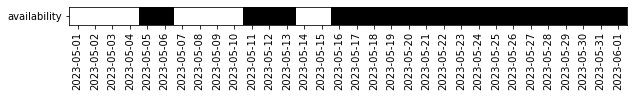

In [9]:
# Remove unnecessary columns and plot.
tremor_availability = tremor_availability[['time','availability']]
plot_availability(tremor_availability)

In this example, there is good coverage, but no tremor data on May 1-4, 7-10, and 14-15.

**Note:** A `1` indicates that *at least one data point* is available for a chosen day.

### Adjusting resolution

The size of time bins can be increased or decreased by adjusting the `resolution` parameter, depending on desired precision vs. efficiency. Resolution can be specified between five minutes (300 seconds) and one day (86400 seconds). ([see the stream availability API documentation](https://docs.runelabs.io/stream/v2/#tag/single-stream/paths/~1streams~1%7Bstream_id%7D~1availability/get))

---

## Data Availability: Multiple Streams

In many situations, there are multiple streams of interest. For example, one might be interested in data from multiple devices, or with multiple combinations of parameters. In such situations, it may be more convenient to use the SDK's "batch availability" tools.

For example, a patient may have similar streams from different device IDs.

In [10]:
# Query for specific tremor streams.
tremor_metadata = get_patient_stream_metadata(patient_id=patient_id, algorithm='ingest-strive-applewatch-md.0', measurement='tremor', severity='all', stream_type_id='duration')
tremor_metadata_df = tremor_metadata.to_dataframe()
tremor_metadata_df

,created_at,algorithm,device_id,patient_id,stream_type,min_time,max_time,parameters,category,severity,measurement,id
0,1.655410e+09,ingest-strive-applewatch-md.0,IPl2_ivn,e3dd146f74714135a11128e99f1557f0,"{'name': 'Duration', 'description': 'Durations...",1.655103e+09,1.655146e+09,"{'category': 'symptom', 'severity': 'all', 'me...",symptom,all,tremor,183bcc1a06cf729db3aa36937fd509124229f1422a14bf...
1,1.668829e+09,ingest-strive-applewatch-md.0,LARICRKw,e3dd146f74714135a11128e99f1557f0,"{'name': 'Duration', 'description': 'Durations...",1.668225e+09,1.693247e+09,"{'category': 'symptom', 'severity': 'all', 'me...",symptom,all,tremor,83257a46c877b96f4c639d2d3961401baf27d50b69f777...
2,1.655409e+09,ingest-strive-applewatch-md.0,YLoNpWkC,e3dd146f74714135a11128e99f1557f0,"{'name': 'Duration', 'description': 'Durations...",1.655103e+09,1.655121e+09,"{'category': 'symptom', 'severity': 'all', 'me...",symptom,all,tremor,272a2741dbaf268074d5d46fb83614985d65a57f260296...


These streams came from different devices, in this case, different Apple Watches that the user had at different times.

The availability representation of one of these streams only indicates when data was generated by one device. To find when data was generated by *any* watch, use the [get_batch_availability_dataframe()](https://runeq.readthedocs.io/en/latest/pages/resources.html#runeq.resources.stream_metadata.StreamMetadata.get_stream_availability_dataframe) function of the StreamMetadataSet object.

Note that this function requires one additional parameter: `batch_operation`. The [API docs](https://docs.runelabs.io/stream/v2/#tag/multi-stream/paths/~1batch~1availability/get) explain this parameter, which can take on two possible values: `any` or `all`.

* With the `any` operation (which is essentially a bitwise OR), a `1` will be returned for a bin if *any* stream has data during the associated time period.
* With the `all` operation (which is essentially a bitwise AND), a `1` will be returned for a bin if *all* streams have data during the associated time period.

Since we're looking for data from *any* watch, we'll use the *any* operation:

In [11]:
# Pull the availability representation for the set of streams in the StreamMetadataSet.
batch_tremor_availability = tremor_metadata.get_batch_availability_dataframe(
    start_time=start_time,
    end_time=end_time,
    resolution=resolution,
    batch_operation='any',
)

batch_tremor_availability.head()

,time,availability
0,2023-05-01T00:00:00Z,0
1,2023-05-02T00:00:00Z,0
2,2023-05-03T00:00:00Z,0
3,2023-05-04T00:00:00Z,0
4,2023-05-05T00:00:00Z,1


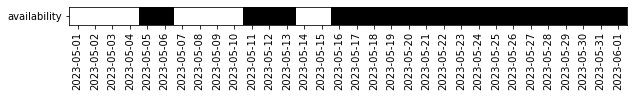

In [12]:
# Plot availability.
plot_availability(batch_tremor_availability)

In this case, the result is the same, because only one device was active during the queried time period.

This functionality is also useful for data from a single device. For example, local field potential (LFP) data from a DBS device might be recorded using different settings at different times (e.g., center frequency, sensing electrodes). To find LFP data regardless of those settings, query without specifying them, and then pull the batch availability of the resulting StreamMetadataSet using the `any` operation.

### Overlapping data

One very useful application of the `all` operation is to find *overlapping* data. For example, it can be used to find times when both tremor and LFP data are available, so that relationships between the two can be analyzed.

Here, we'll find overlapping tremor and step count data (which is gathered by Apple Health using the iPhone and Apple Watch):

In [13]:
from runeq.resources.stream_metadata import StreamMetadataSet

# Query for step count streams.
step_count_metadata = get_patient_stream_metadata(patient_id=patient_id, algorithm='ingest-strive-healthkit.1', measurement='step_count', hk_aggregation='true')

# Combine the stream metadata for both into one StreamMetadataSet.
combined_metadata = StreamMetadataSet(step_count_metadata)
combined_metadata.add(tremor_stream)
combined_metadata.to_dataframe()

,created_at,algorithm,device_id,patient_id,stream_type,min_time,max_time,parameters,category,hk_aggregation,measurement,function,id,severity
0,1.700706e+09,ingest-strive-healthkit.1,g_kooa6y,e3dd146f74714135a11128e99f1557f0,"{'name': 'Count', 'description': 'Count of eve...",1.684070e+09,1.685812e+09,"{'category': 'motion', 'hk_aggregation': 'true...",motion,true,step_count,sum,f1e284ad80de034cd8d133f2dffdd87b603bd891c7cd6f...,NaN
1,1.668829e+09,ingest-strive-applewatch-md.0,LARICRKw,e3dd146f74714135a11128e99f1557f0,"{'name': 'Duration', 'description': 'Durations...",1.668225e+09,1.693247e+09,"{'category': 'symptom', 'severity': 'all', 'me...",symptom,NaN,tremor,NaN,83257a46c877b96f4c639d2d3961401baf27d50b69f777...,all


A new StreamMetadataSet object was created from the step count metadata, and then the previously queried tremor stream was added to it, forming a combined set of streams.

Now, the batch availability operation can be used on this combined set:

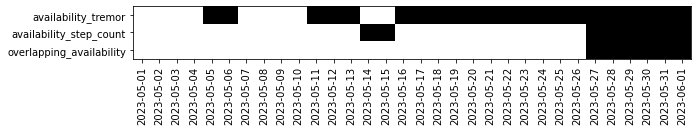

In [14]:
# Pull the overlapping availability representation for the combined set of streams.
overlapping_availability = combined_metadata.get_batch_availability_dataframe(
    start_time=start_time,
    end_time=end_time,
    resolution=resolution,
    batch_operation='all',
)

# Pull the availability representation for just the step count stream, for comparison.
step_count_availability = step_count_metadata.get_batch_availability_dataframe(
    start_time=start_time,
    end_time=end_time,
    resolution=resolution,
    batch_operation='any',
)

# Combine dataframes by merging on the timestamps.
combined_availability = tremor_availability.merge(step_count_availability, on='time', suffixes=('_tremor','_step_count'))
combined_availability = combined_availability.merge(overlapping_availability, on='time')
combined_availability = combined_availability.rename(columns={'availability': 'overlapping_availability'})

# Visualize the result.
plot_availability(combined_availability)

Step count data is available for May 14-15, but no tremor data is available for those days. The only days with data of both types available are May 27-31.

Again, this only indicates that there is at least one data point of each type during each day. It is possible (though unlikely) that these data are available at different times during a day. To investigate further, one could adjust the `resolution` parameter for increased precision. Because timestamps produced by different algorithms or devices are unlikely to match perfectly, finding overlap in the data itself would likely require a binning operation. The binning inherent in these availability representations is often a sufficient shortcut (depending on the desired resolution).

---

This concludes the basic tutorials for exploring and pulling data from the Rube Labs platform using our API/SDK.

For more examples focused on specific use cases, please see the list of available examples in the repository [README](README.md).